# PPN Dynamic Filtering

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, ThresholdedReLU
from keras.layers import Convolution2D, MaxPooling2D, InputLayer
from keras.regularizers import activity_l2
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import backend as K

from ppap.layers import PPDFN, DFN, PPFN
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Modified version of keras/examples/mnist_cnn.py

batch_size = 100
nb_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
# pool_size = (2, 2)
# convolution kernel size
# kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explicitly set dim ordering to theano
K.set_image_dim_ordering('th')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [10]:
modelPP = Sequential()
modelPP.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
modelPP.add(PPDFN(5))
modelPP.add(Activation('relu'))
modelPP.add(Flatten())
modelPP.add(Dense(nb_classes))
modelPP.add(Activation('softmax'))

model = Sequential()
model.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
model.add(DFN(5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

modelC = Sequential()
modelC.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
modelC.add(Convolution2D(1, 5, 5, border_mode="same"))
modelC.add(Activation('relu'))
modelC.add(Flatten())
modelC.add(Dense(nb_classes))
modelC.add(Activation('softmax'))

modelP = Sequential()
modelP.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
modelP.add(PPFN(5))
modelP.add(Activation('relu'))
modelP.add(Flatten())
modelP.add(Dense(nb_classes))
modelP.add(Activation('softmax'))

In [11]:
modelPP.summary()
model.summary()
modelC.summary()
modelP.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (100, 1, 28, 28)      0                                            
____________________________________________________________________________________________________
ppdfn_3 (PPDFN)                  (100, 1, 28, 28)      670         input_9[0][0]                    
____________________________________________________________________________________________________
activation_15 (Activation)       (100, 1, 28, 28)      0           ppdfn_3[0][0]                    
____________________________________________________________________________________________________
flatten_8 (Flatten)              (100, 784)            0           activation_15[0][0]              
___________________________________________________________________________________________

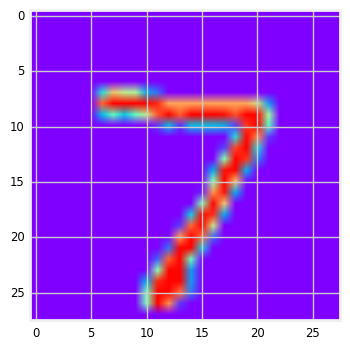

In [12]:
test_index = 0
plt.imshow(X_test[test_index, 0])

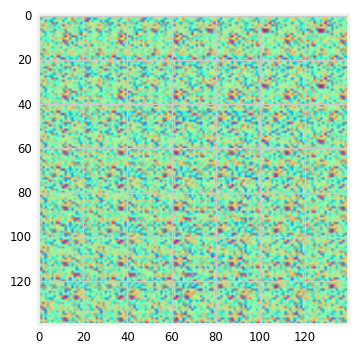

In [13]:
fs = get_filter(modelPP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

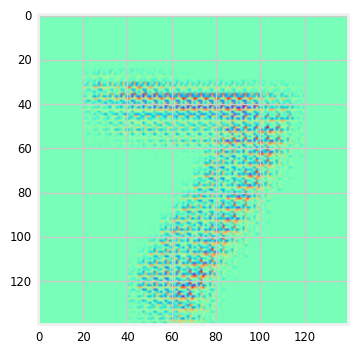

In [14]:
fs = get_filter(model, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

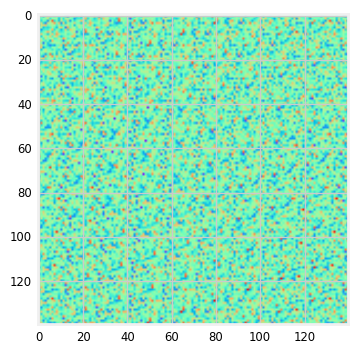

In [15]:
fs = get_filter(modelP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

In [16]:
modelP.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
modelP.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s - loss: 0.4376 - acc: 0.8724 - val_loss: 0.2403 - val_acc: 0.9319
Epoch 2/10
60000/60000 [==============================] - 17s - loss: 0.2085 - acc: 0.9396 - val_loss: 0.1749 - val_acc: 0.9493
Epoch 3/10
60000/60000 [==============================] - 17s - loss: 0.1615 - acc: 0.9533 - val_loss: 0.1437 - val_acc: 0.9586
Epoch 4/10
60000/60000 [==============================] - 19s - loss: 0.1357 - acc: 0.9615 - val_loss: 0.1250 - val_acc: 0.9621
Epoch 5/10
60000/60000 [==============================] - 19s - loss: 0.1182 - acc: 0.9656 - val_loss: 0.1170 - val_acc: 0.9643
Epoch 6/10
60000/60000 [==============================] - 18s - loss: 0.1052 - acc: 0.9690 - val_loss: 0.1061 - val_acc: 0.9663
Epoch 7/10
60000/60000 [==============================] - 18s - loss: 0.0962 - acc: 0.9714 - val_loss: 0.1016 - val_acc: 0.9680
Epoch 8/10
60000/60000 [==============================

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 72s - loss: 0.4348 - acc: 0.8702 - val_loss: 0.2720 - val_acc: 0.9208
Epoch 2/10
60000/60000 [==============================] - 93s - loss: 0.2550 - acc: 0.9260 - val_loss: 0.2163 - val_acc: 0.9372
Epoch 3/10
60000/60000 [==============================] - 83s - loss: 0.2097 - acc: 0.9395 - val_loss: 0.1782 - val_acc: 0.9475
Epoch 4/10
60000/60000 [==============================] - 86s - loss: 0.1809 - acc: 0.9471 - val_loss: 0.1556 - val_acc: 0.9555
Epoch 5/10
60000/60000 [==============================] - 83s - loss: 0.1593 - acc: 0.9533 - val_loss: 0.1437 - val_acc: 0.9575
Epoch 6/10
60000/60000 [==============================] - 91s - loss: 0.1429 - acc: 0.9584 - val_loss: 0.1284 - val_acc: 0.9617
Epoch 7/10
60000/60000 [==============================] - 95s - loss: 0.1313 - acc: 0.9610 - val_loss: 0.1237 - val_acc: 0.9628
Epoch 8/10
60000/60000 [==============================

In [20]:
modelPP.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
modelPP.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 75s - loss: 0.4336 - acc: 0.8726 - val_loss: 0.2478 - val_acc: 0.9291
Epoch 2/10
60000/60000 [==============================] - 89s - loss: 0.2279 - acc: 0.9333 - val_loss: 0.1720 - val_acc: 0.9496
Epoch 3/10
60000/60000 [==============================] - 81s - loss: 0.1666 - acc: 0.9504 - val_loss: 0.1308 - val_acc: 0.9612
Epoch 4/10
60000/60000 [==============================] - 92s - loss: 0.1350 - acc: 0.9597 - val_loss: 0.1160 - val_acc: 0.9664
Epoch 5/10
60000/60000 [==============================] - 83s - loss: 0.1148 - acc: 0.9657 - val_loss: 0.1010 - val_acc: 0.9698
Epoch 6/10
60000/60000 [==============================] - 91s - loss: 0.1020 - acc: 0.9697 - val_loss: 0.0905 - val_acc: 0.9717
Epoch 7/10
60000/60000 [==============================] - 94s - loss: 0.0928 - acc: 0.9718 - val_loss: 0.0954 - val_acc: 0.9710
Epoch 8/10
60000/60000 [==============================

In [18]:
modelC.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
modelC.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s - loss: 0.6274 - acc: 0.8293 - val_loss: 0.3209 - val_acc: 0.9106
Epoch 2/10
60000/60000 [==============================] - 12s - loss: 0.3167 - acc: 0.9096 - val_loss: 0.2893 - val_acc: 0.9200
Epoch 3/10
60000/60000 [==============================] - 9s - loss: 0.2905 - acc: 0.9175 - val_loss: 0.2768 - val_acc: 0.9215
Epoch 4/10
60000/60000 [==============================] - 11s - loss: 0.2786 - acc: 0.9208 - val_loss: 0.2611 - val_acc: 0.9273
Epoch 5/10
60000/60000 [==============================] - 14s - loss: 0.2710 - acc: 0.9232 - val_loss: 0.2630 - val_acc: 0.9269
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 0.2644 - acc: 0.9253 - val_loss: 0.2673 - val_acc: 0.9240
Epoch 7/10
60000/60000 [==============================] - 11s - loss: 0.2606 - acc: 0.9271 - val_loss: 0.2621 - val_acc: 0.9258
Epoch 8/10
60000/60000 [==============================] 

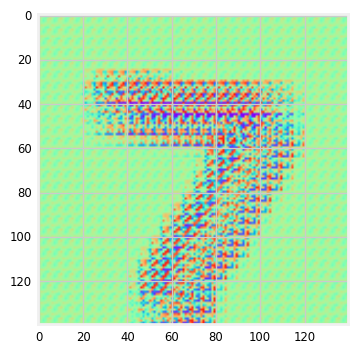

In [21]:
fs = get_filter(model, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

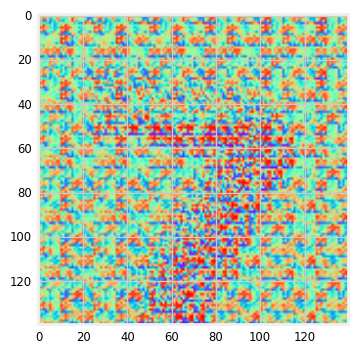

In [22]:
fs = get_filter(modelPP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

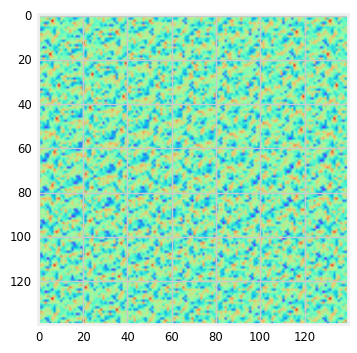

In [23]:
fs = get_filter(modelP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))